In [2]:
%load_ext autoreload
%autoreload 2

In [10]:
import pickle
import pandas as pd
import numpy as np
import os
import subprocess

# Exploration initial peaks sets

In [37]:
TIME_POINT = ["D8", "D12", "D20", "D22"]
data_path = "../data/peaks/"

peaks_per_rep = []
for t in TIME_POINT:
    peaks_rep1, peaks_rep2 = data_path + t + "_1.bed", data_path + t + "_2.bed"
    peaks_rep1, peaks_rep2 =  pd.read_csv(peaks_rep1 ,header=None, sep='\t', skiprows=range(0, 50)), pd.read_csv(peaks_rep2 ,header=None, sep='\t', skiprows=range(0, 50))
    
    #Remove scaffold chromosomes
    peaks_rep1 = peaks_rep1[np.logical_or(np.logical_or(peaks_rep1[0].str.isnumeric(), peaks_rep1[0] == 'X'), peaks_rep1[0] == 'Y')]
    peaks_rep2 = peaks_rep2[np.logical_or(np.logical_or(peaks_rep2[0].str.isnumeric(), peaks_rep2[0] == 'X'), peaks_rep2[0] == 'Y')]

    #Merge overlapping peaks
    if not os.path.exists('../results/tmp/'):
        os.makedirs('../results/tmp/')

    peaks = pd.concat([peaks_rep1, peaks_rep2])
    peaks_path = "../results/tmp/peaks.bed"
    peaks.to_csv(peaks_path, header=False, index=False, sep='\t')
    
    sort_bed = "sortBed -i " + peaks_path + " > ../results/tmp/peaks_sorted.bed"
    subprocess.run(sort_bed, shell=True)

    merge_bedtools = "bedtools merge -i ../results/tmp/peaks_sorted.bed -c 1 -o count > ../results/tmp/count_peaks.bed"
    subprocess.run(merge_bedtools, shell=True)
    
    #Only keep peaks that were in both replicates
    peaks = pd.read_csv("../results/tmp/count_peaks.bed" ,header=None, sep='\t', low_memory=False)
    peaks = peaks[peaks[3] == 2]
    peaks.to_csv("../results/tmp/count_peaks.bed", header=False, index=False, sep='\t')

    print(f"Total number peaks rep1, rep2: {peaks_rep1.shape[0]}, {peaks_rep2.shape[0]}")
    print(f"Number of overlapping peaks: {peaks.shape[0]}")
    print(f"Discaded peak {(peaks_rep1.shape[0]+peaks_rep2.shape[0]) - 2*peaks.shape[0]}")

    #Check peaks are not inside blacklisted regions of genome
    subprocess.run("bedtools intersect -a ../results/tmp/count_peaks.bed -b ../data/hg38_blacklist.bed -v > ../results/" + t +"_common_peaks.bed", shell=True)


Total number peaks rep1, rep2: 211840, 215279
Number of overlapping peaks: 181675
Discaded peak 63769
Total number peaks rep1, rep2: 218325, 213815
Number of overlapping peaks: 187015
Discaded peak 58110
Total number peaks rep1, rep2: 233769, 240725
Number of overlapping peaks: 206752
Discaded peak 60990
Total number peaks rep1, rep2: 199520, 210183
Number of overlapping peaks: 163582
Discaded peak 82539


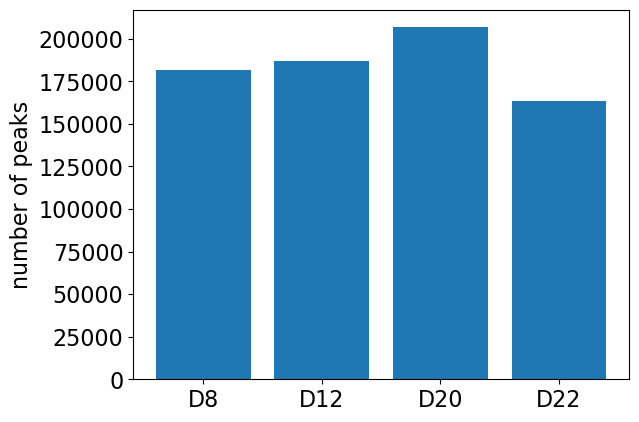

In [77]:
import matplotlib.pyplot as plt

nb_peaks = np.array([181675, 187015, 206752, 163582])

plt.bar(TIME_POINT, nb_peaks)
plt.ylabel("number of peaks")
plt.rcParams.update({'font.size': 14})
plt.show()

In [59]:

percentages_overlap = np.zeros((4,4))
for i, t in enumerate(TIME_POINT):

    peaks1 = pd.read_csv("../results/"+ t + "_common_peaks.bed" ,header=None, sep='\t', low_memory=False)

    for j in range(0, len(TIME_POINT)):
        peaks2 = pd.read_csv("../results/"+ TIME_POINT[j] + "_common_peaks.bed"  ,header=None, sep='\t', low_memory=False)
        
        #Concat peaks in bed file
        peaks = pd.concat([peaks1, peaks2])
        peaks_path = "../results/tmp/peaks.bed"
        peaks.to_csv(peaks_path, header=False, index=False, sep='\t')

        sort_bed = "sortBed -i ../results/tmp/peaks.bed > ../results/tmp/peaks_sorted.bed"
        subprocess.run(sort_bed, shell=True)        

        merge_bedtools = "bedtools merge -i ../results/tmp/peaks_sorted.bed -c 1 -o count > ../results/tmp/count_peaks.bed"
        subprocess.run(merge_bedtools, shell=True)

        peaks = pd.read_csv("../results/tmp/count_peaks.bed" ,header=None, sep='\t', low_memory=False)
        perc_overlap = np.sum(peaks[3] == 2)/len(peaks)

        print(t, TIME_POINT[j])
        print(f"Percentage overlap peaks: {perc_overlap}")

        percentages_overlap[i,j] = perc_overlap



D8 D8
Percentage overlap peaks: 1.0
D8 D12
Percentage overlap peaks: 0.5757596622671308
D8 D20
Percentage overlap peaks: 0.44821398277129554
D8 D22
Percentage overlap peaks: 0.4208518621745406
D12 D8
Percentage overlap peaks: 0.5757596622671308
D12 D12
Percentage overlap peaks: 1.0
D12 D20
Percentage overlap peaks: 0.5870472490541655
D12 D22
Percentage overlap peaks: 0.5097510102985269
D20 D8
Percentage overlap peaks: 0.44821398277129554
D20 D12
Percentage overlap peaks: 0.5870472490541655
D20 D20
Percentage overlap peaks: 1.0
D20 D22
Percentage overlap peaks: 0.5844114441299506
D22 D8
Percentage overlap peaks: 0.4208518621745406
D22 D12
Percentage overlap peaks: 0.5097510102985269
D22 D20
Percentage overlap peaks: 0.5844114441299506
D22 D22
Percentage overlap peaks: 1.0


<Axes: >

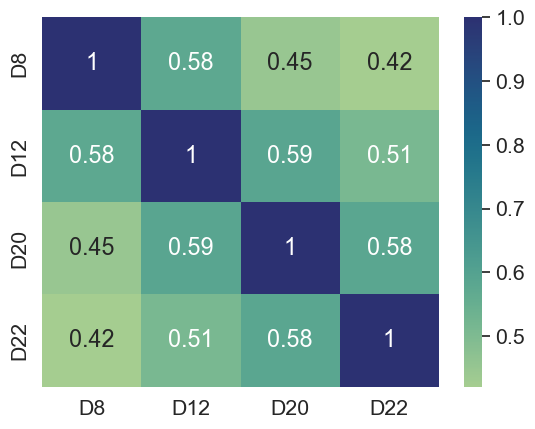

In [81]:
import seaborn as sns

percentages_overlap = pd.DataFrame(percentages_overlap)
percentages_overlap.index = TIME_POINT; percentages_overlap.columns = TIME_POINT

sns.set_theme(font_scale=1.4)
sns.heatmap(percentages_overlap, annot=True, cmap="crest")

# Overlap between Cut&Tag motif and ATAC peaks set

In [39]:
#Open peak pandas dataframe and write to .bed file
with open('../results/peaks_seq.pkl', 'rb') as file:
    peaks = pickle.load(file)

peaks

,chr,start,end,middle_peak,sequence,GC_cont
peakID,,,,,,
1:14154-15100,1,14154,15100,14627,GCCCACCGGCCCCAGGCTCCTGTCTCCCCCCAGGTGTGTGGTGATG...,0.585938
1:15698-16677,1,15698,16677,16188,GGCCATTAGGCTCTCAGCATGACTATTTTTAGAGACCCCGTGTCTG...,0.599854
1:17116-17963,1,17116,17963,17540,GGCTGACCATTGCCTTGGACCGCTCTTGGCAGTCGAAGAAGATTCT...,0.597168
1:28903-29812,1,28903,29812,29358,CACATGCAGCCACTGAGCACTTGAAATGTGGATAGTCTGAATTGAG...,0.489746
1:180637-181553,1,180637,181553,181095,ATGCTGATGGATTGTCAGCTTCCCAGATGTGCAAGAATCTCTCCTC...,0.537109
...,...,...,...,...,...,...
Y:56724332-56725266,Y,56724332,56725266,56724799,ACGGAATGGAATGGAATCCAAAGGAATGGAATAGAATGGAATGGAA...,0.389404
Y:56727619-56728608,Y,56727619,56728608,56728114,TGGAATGCACTCGAATGCAATGGAGTCGAAACAAATGGACTGGAAT...,0.391602
Y:56763067-56763979,Y,56763067,56763979,56763523,TGGAAGGGAGTGTAATGCAAGGTTCTCGAAAATAATGGAATCGAAT...,0.393555


In [40]:
peaks.chr = ["chr" + str(c) for c in peaks.chr]
peaks[["chr","start","end"]].to_csv('../results/all_peaks.bed', sep="\t", index=False, header=False)

In [20]:
#Compute intersection between genomic regions

#MyoD1
!bedtools intersect -a ../results/all_peaks.bed -b ../data/MYOD1_25m_s450.bed > ../results/MyoD1_intersect.bed

MYOD1 = pd.read_csv("../results/MyoD1_intersect.bed", header=None, sep= "\t")
print(MYOD1)

#HES1
!bedtools intersect -a ../results/all_peaks.bed -b ../data/HES1_D8_REP1_filt_TFBS_HES1_s400.bed > ../results/HES1_intersect.bed

HES1 = pd.read_csv("../results/HES1_intersect.bed", header=None, sep= "\t")
print(HES1)

#PAX3
!bedtools intersect -a ../results/all_peaks.bed -b ../data/PAX3_D8_REP1_s500.bed > ../results/PAX3_intersect.bed

PAX3 = pd.read_csv("../results/PAX3_intersect.bed", header=None, sep= "\t")
print(PAX3)

        0          1          2
0    chr1    1291915    1291924
1    chr1    2161426    2161435
2    chr1    3491910    3491919
3    chr1    3900603    3900612
4    chr1    9129736    9129745
..    ...        ...        ...
669  chr9  133492314  133492323
670  chr9  134658563  134658572
671  chr9  136842853  136842862
672  chrX  134192374  134192383
673  chrX  145817356  145817365

[674 rows x 3 columns]
         0          1          2
0     chr1     827781     827789
1     chr1     920726     920734
2     chr1    1232109    1232117
3     chr1    1304858    1304866
4     chr1    1304860    1304868
...    ...        ...        ...
1505  chrX  154341982  154341990
1506  chrX  154390123  154390131
1507  chrX  154479022  154479030
1508  chrX  154479056  154479064
1509  chrY   19567275   19567283

[1510 rows x 3 columns]
        0          1          2
0    chr1    1064373    1064387
1    chr1   67430692   67430706
2    chr1  209879463  209879477
3    chr1  222382459  222382469
4    chr1  

# Overlap between exonic regions and ATAC peaks

An overlap is defied as a peak having having at least half of its region inside an exonic region

In [31]:
exons = pd.read_csv("../data/ensemble_exon_sequences.bed", header=None, sep= "\t")
exons[0] = ["chr" + str(c) for c in exons[0]] 
exons.to_csv('../data/ensemble_exon_sequences.bed', sep="\t", index=False, header=False)

exons

/var/folders/nx/fx90wvl146lcdkglfty5_wr4qnvn43/T/ipykernel_15915/2411707598.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  exons = pd.read_csv("../data/ensemble_exon_sequences.bed", header=None, sep= "\t")


,0,1,2
0,chr1,182696,182746
1,chr1,183132,183216
2,chr1,183494,183571
3,chr1,183740,183901
4,chr1,183981,184174
...,...,...,...
1575544,chr21,31706555,31706864
1575545,chr21,31735732,31736407
1575546,chr21,36156782,36156943
1575547,chr21,36164708,36164871


In [42]:
peaks = pd.read_csv("../results/all_peaks.bed", header=None, sep= "\t")
peaks

,0,1,2
0,chr1,14154,15100
1,chr1,15698,16677
2,chr1,17116,17963
3,chr1,28903,29812
4,chr1,180637,181553
...,...,...,...
297997,chrY,56724332,56725266
297998,chrY,56727619,56728608
297999,chrY,56763067,56763979
298000,chrY,56829118,56830024


In [99]:
import numpy as np
len(np.unique(exons.index))

59315

In [128]:
#Compute the overlap between peak and exonic regions
!bedtools intersect  -f 0.5 -a ../results/all_peaks.bed -b  ../data/ensemble_exon_sequences.bed > ../results/exons_intersect.bed

exons = pd.read_csv("../results/exons_intersect.bed", header=None, sep= "\t")
exons.index = exons[0].astype("string") + ":" + exons[1].astype("string") + "-" + exons[2].astype("string")
exons = exons[~exons.index.duplicated(keep='first')]
exons

,0,1,2
chr1:267600-268204,chr1,267600,268204
chr1:629640-630526,chr1,629640,630526
chr1:633696-634376,chr1,633696,634376
chr1:804776-805328,chr1,804776,805328
chr1:804776-805270,chr1,804776,805270
...,...,...,...
chrY:19041964-19042819,chrY,19041964,19042819
chrY:19042830-19043346,chrY,19042830,19043346
chrY:19043163-19043797,chrY,19043163,19043797
chrY:19603797-19604471,chrY,19603797,19604471
